In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt

import os
import sys

from IPython.display import display, Image

from scipy import ndimage

import random

%matplotlib inline

## Load dataset

## 64\*64

In [2]:
pickle_file = 'SVHN_multi_crop_64.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset_64 = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset_64 = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset_64 = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset_64.shape, train_labels.shape)
    print('Validation set', valid_dataset_64.shape, valid_labels.shape)
    print('Test set', test_dataset_64.shape, test_labels.shape)

Training set (27401, 64, 64) (27401, 6)
Validation set (6000, 64, 64) (6000, 6)
Test set (13068, 64, 64) (13068, 6)


In [3]:
valid_dataset_64 = valid_dataset_64[:2000]
valid_labels = valid_labels[:2000]
print('Validation set', valid_dataset_64.shape, valid_labels.shape)

Validation set (2000, 64, 64) (2000, 6)


In [4]:
image_size = 64

num_channels = 1 # grayscale

def reformat(dataset):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset
train_dataset_64 = reformat(train_dataset_64)
valid_dataset_64 = reformat(valid_dataset_64)
test_dataset_64 = reformat(test_dataset_64)
print('Training set', train_dataset_64.shape, train_labels.shape)
print('Validation set', valid_dataset_64.shape, valid_labels.shape)
print('Test set', test_dataset_64.shape, test_labels.shape)

Training set (27401, 64, 64, 1) (27401, 6)
Validation set (2000, 64, 64, 1) (2000, 6)
Test set (13068, 64, 64, 1) (13068, 6)


In [5]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i][1:5])
        plt.imshow(dataset[i,:,:,0])

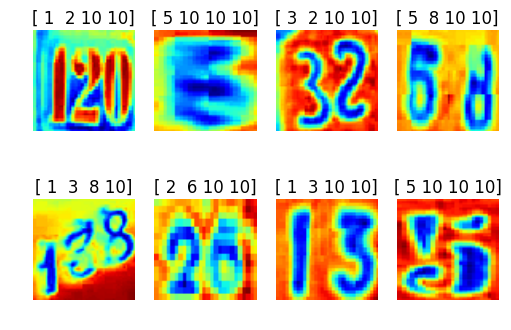

In [6]:
disp_sample_dataset(valid_dataset_64, valid_labels)

## Metrics

In [7]:
def accuracy_single(predictions, labels):
    """calculate character-level accuracy"""
    a = np.argmax(predictions, 2).T == labels[:,1:6]
    length = labels[:,0]
    summ = 0.0
    for i in range(len(length)):
        summ += np.sum(a[i,:length[i]])
    #     print(a[i,:length[i]])
    return(100 * summ / np.sum(length))

In [8]:
def accuracy_multi(predictions, labels):
    """calculate sequence-level accuracy"""
    count = predictions.shape[1]
    return 100.0 * (count - np.sum([1 for i in np.argmax(predictions, 2).T == labels[:,1:6]\
                                    if False in i])) / count

## Model

In [9]:
batch_size = 64
patch_size = 5 # conv kernel size
depth1 = 16
depth2 = 32
depth3 = 128
num_hidden = 128

image_size = 64
num_labels = 11 
num_channels = 1 # grayscale

graph = tf.Graph()

with graph.as_default():

    def get_weight_variable(name, shape):
        return tf.get_variable(name, shape=shape,\
                               initializer=tf.contrib.layers.xavier_initializer_conv2d())

    def bias_variable(shape):
        initial = tf.constant(1.0, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'VALID')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    def get_label_wb(weight_name):
        weights = tf.get_variable(weight_name, shape=[num_hidden, num_labels],\
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        return weights, biases 
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset_64)
    tf_test_dataset = tf.constant(test_dataset_64)
    beta_regul = tf.placeholder(tf.float32)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = get_weight_variable('CNN_W1', [7, 7, num_channels, depth1])
    layer1_biases = bias_variable([depth1]) # 16
    # conv2 layer 2
    layer2_weights = get_weight_variable('CNN_W2', [patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2]) # 32
    # conv3 layer 3
    layer3_weights = get_weight_variable('CNN_W3', [5, 5, depth2, depth3])
    layer3_biases = bias_variable([depth3]) # 64
    
    # func1 layer 4
    layer4_weights = get_weight_variable('FC_W1',[3200, num_hidden])
    layer4_biases = bias_variable([num_hidden])
    
    # locally connected layers
    s1_w, s1_b = get_label_wb('S1_W')
    s2_w, s2_b = get_label_wb('S2_W')
    s3_w, s3_b = get_label_wb('S3_W')
    s4_w, s4_b = get_label_wb('S4_W')
    s5_w, s5_b = get_label_wb('S5_W')
    
    sw = [s1_w, s2_w, s3_w, s4_w, s5_w]
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset, keep_prob, keep_prob2):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
        hidden1 = tf.nn.local_response_normalization(hidden1)
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
        hidden2 = tf.nn.local_response_normalization(hidden2)
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
        
        pool2 = tf.nn.dropout(pool2, keep_prob2)
        
        # conv3 layer 3
        hidden3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 8 * 8 * depth3
        hidden3 = tf.nn.local_response_normalization(hidden3)
        pool3 = max_pooling(hidden3) # 4 * 4 * depth3
        
        pool3 = tf.nn.dropout(pool3, keep_prob2)
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]]) # 1024
#         print(shape[0], shape[1] * shape[2] * shape[3])
        
        # func1 layer 4
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, keep_prob)

        logits_1 = tf.matmul(hidden4_drop, s1_w) + s1_b
        logits_2 = tf.matmul(hidden4_drop, s2_w) + s2_b
        logits_3 = tf.matmul(hidden4_drop, s3_w) + s3_b
        logits_4 = tf.matmul(hidden4_drop, s4_w) + s4_b
        logits_5 = tf.matmul(hidden4_drop, s5_w) + s5_b
        
        return [logits_1, logits_2, logits_3, logits_4, logits_5]
    
    # Training computation.
    logits = model(tf_train_dataset, 0.5, 0.8)
    
    loss_per_digit = [tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[:,i+1]
                        )) + beta_regul * tf.nn.l2_loss(sw[i])
                       for i in range(5)]
    
    loss = tf.add_n(loss_per_digit)

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.001, global_step, 1000, 0.90, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    def prediction_softmax(dataset):
        prediction = tf.pack([
            tf.nn.softmax(model(dataset, 1.0, 1.0)[0]),
            tf.nn.softmax(model(dataset, 1.0, 1.0)[1]),
            tf.nn.softmax(model(dataset, 1.0, 1.0)[2]),
            tf.nn.softmax(model(dataset, 1.0, 1.0)[3]),
            tf.nn.softmax(model(dataset, 1.0, 1.0)[4])])
        return prediction
    
    # Predictions for the training, validation, and test data.
    train_prediction = prediction_softmax(tf_train_dataset)
    valid_prediction = prediction_softmax(tf_valid_dataset)             
    test_prediction = prediction_softmax(tf_test_dataset)
    
    # Save Model 
    saver = tf.train.Saver()

In [10]:
num_steps = 10001

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset_64[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch single digit accuracy: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch image accuracy: %.1f%%' % accuracy_multi(predictions, batch_labels))
            print('Validation single digit accuracy: %.1f%%' % accuracy_single(valid_prediction.eval(), valid_labels))
            print('Validation image accuracy: %.1f%%' % accuracy_multi(valid_prediction.eval(), valid_labels))
            
    print('Test single digit accuracy: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test image accuracy: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))
    
        
    save_path = saver.save(session, "cnn_64_1.ckpt")
    print('Model saved in file: {}'.format(save_path))

Initialized
Minibatch loss at step 0: 18.899332
Minibatch single digit accuracy: 10.3%
Minibatch image accuracy: 0.0%
Validation single digit accuracy: 18.5%
Validation image accuracy: 1.1%
Minibatch loss at step 500: 5.470881
Minibatch single digit accuracy: 18.1%
Minibatch image accuracy: 4.7%
Validation single digit accuracy: 18.5%
Validation image accuracy: 3.0%
Minibatch loss at step 1000: 3.840863
Minibatch single digit accuracy: 54.7%
Minibatch image accuracy: 37.5%
Validation single digit accuracy: 48.4%
Validation image accuracy: 27.9%
Minibatch loss at step 1500: 3.556161
Minibatch single digit accuracy: 61.8%
Minibatch image accuracy: 43.8%
Validation single digit accuracy: 60.9%
Validation image accuracy: 43.5%
Minibatch loss at step 2000: 2.847495
Minibatch single digit accuracy: 69.1%
Minibatch image accuracy: 57.8%
Validation single digit accuracy: 71.6%
Validation image accuracy: 57.8%
Minibatch loss at step 2500: 2.605237
Minibatch single digit accuracy: 73.6%
Minibatc

In [ ]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    
    # If you want to restore model
    saver.restore(session, "cnn_64_1.ckpt")
    print("Model restored!")

#     tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset_64[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            predictions = predictions
            print('Minibatch single digit accuracy: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch image accuracy: %.1f%%' % accuracy_multi(predictions, batch_labels))
            valid_prediction = valid_prediction
            print('Validation single digit accuracy: %.1f%%' % accuracy_single(valid_prediction.eval(), valid_labels))
            print('Validation image accuracy: %.1f%%' % accuracy_multi(valid_prediction.eval(), valid_labels))
    test_prediction = test_prediction        
    print('Test single digit accuracy: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test image accuracy: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))
    
        
    save_path = saver.save(session, "cnn_64_1.ckpt")
    print('Model saved in file: {}'.format(save_path))

Model restored!
Initialized
Minibatch loss at step 0: 1.016246
Minibatch single digit accuracy: 96.3%
Minibatch image accuracy: 92.2%
Validation single digit accuracy: 86.0%
Validation image accuracy: 77.0%
Minibatch loss at step 500: 0.938107
Minibatch single digit accuracy: 95.7%
Minibatch image accuracy: 92.2%
Validation single digit accuracy: 86.0%
Validation image accuracy: 76.5%
Minibatch loss at step 1000: 0.759440
Minibatch single digit accuracy: 94.9%
Minibatch image accuracy: 90.6%
Validation single digit accuracy: 86.4%
Validation image accuracy: 77.4%
Minibatch loss at step 1500: 0.957170
Minibatch single digit accuracy: 92.4%
Minibatch image accuracy: 87.5%
Validation single digit accuracy: 86.3%
Validation image accuracy: 77.5%
Minibatch loss at step 2000: 1.220409
Minibatch single digit accuracy: 86.8%
Minibatch image accuracy: 79.7%
Validation single digit accuracy: 86.4%
Validation image accuracy: 77.7%
Minibatch loss at step 2500: 1.109501
Minibatch single digit accur